In [1]:
from fastai.vision.all import *
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from sklearn.model_selection import train_test_split
from timm import create_model
from fastai.vision.learner import _update_first_layer
from sklearn.metrics import roc_auc_score
from model import *

In [2]:
path = Path('/home/azaidi/Desktop/kaggle/seti_2021')
Path.BASE_PATH = path
path.ls()
train_df = pd.read_csv(path/'data/train_labels.csv')
sub_df = pd.read_csv(path/'data/sample_submission.csv')
data_path = path/'data'
train_df['path'] = train_df['id'].apply(lambda x: str(data_path/'train'/x[0]/x)+'.npy')
train_df.shape

(50165, 3)

In [15]:
t_df, v_df = train_test_split(train_df, test_size=0.1)

In [3]:
class SetiDS(Dataset):
    def __init__(self, df, transforms=None, one_hot=False):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        target = torch.tensor(self.df.iloc[idx].target)
        path = self.df.iloc[idx].path
        
        #the samples are all a 6x273x256 matrix
        x = np.load(path).astype(np.float32)[[0,2,4]] #3x273x256
        x = np.vstack(x)  #819x256
        x = x.transpose((1,0)) # 256x1638 now
        
        if self.transforms:
            x = self.transforms(image=x)['image']
        
        x = torch.tensor(x).float().unsqueeze(0)
        
        
        return x, target#torch.tensor(target)

In [4]:
#np.random.beta??

In [5]:
#np.random.beta(0.4, 0.4)

In [6]:
#nn.functional.one_hot(lbls[0])

In [7]:
#nn.functional.one_hot(torch.stack(lbls))

In [8]:
#lbls = []
#for x in range(10):
#    lbls.append(t_ds[x][1])
#lbls

In [9]:
#torch.stack(lbls)

In [9]:
def get_tfms(train_sz, val_sz):
    train_tfm = A.Compose([
            A.Resize(512,512),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomResizedCrop(train_sz,train_sz)
        ])

    valid_tfm = A.Compose([
            A.Resize(val_sz,val_sz),
        ])
    return train_tfm, valid_tfm

In [11]:
train_tfm, valid_tfm = get_tfms(256, 448)

In [13]:
def get_dls(train_sz, val_sz, bs):
    train_tfm, val_tfm = get_tfms(train_sz, val_sz)
    t_ds = SetiDS(t_df, train_tfm)
    v_ds = SetiDS(v_df, valid_tfm)
    train_dl = DataLoader(t_ds, batch_size=bs,
                     num_workers=8)
    valid_dl = DataLoader(v_ds, batch_size=bs,
                     num_workers=8)

    dls = DataLoaders(train_dl, valid_dl)
    return dls

In [16]:
dls = get_dls(256, 448, 128)

Uncomment the lines below to confirm that our dataloaders are returning the desired/expected tensor sizes for our model

In [21]:
batch = next(iter(dls.train))
batch[0].shape, batch[1].shape

(torch.Size([128, 1, 256, 256]), torch.Size([128]))

We are quite literally mixing pixels from one image onto the other - the plot function below helps ellucidate this. Play around with the index values and alpha to see how it works

In [88]:
def plot_mixup(batch, idx1, idx2, alpha):
    x1, x2 = batch[0][idx1], batch[0][idx2] 
    x3 = (alpha*x1) + ((1-alpha)*x2)
    y1, y2 = batch[1][idx1], batch[1][idx2] 
    y3 = (alpha*y1) + ((1-alpha)*y2)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1.imshow(x1.squeeze(0))
    ax1.set_title(f"label:{batch[1][idx1]}")
    ax2.imshow(x2.squeeze(0))
    ax2.set_title(f"label:{batch[1][idx2]}")
    ax3.imshow(x3.squeeze(0))
    ax3.set_title("label: {:.2f}".format(y3))
    ax1.set_axis_off(), ax2.set_axis_off(), ax3.set_axis_off()

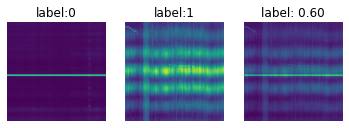

In [89]:
plot_mixup(batch, 1, 14, 0.4)

In [90]:
def roc_auc(preds,targ):
    try: return roc_auc_score(targ.cpu(),preds.squeeze().cpu())
    except: return 0.5

Let's use callbacks to implement mixup -- we're not using all of the features mentioned in the paper  vers

In [94]:
class Mixup(Callback):
    def __init__(self, alpha=0.2):
        self.alpha = np.random.beta(alpha, alpha)
    def before_batch(self):
        if self.training:
            idxs = torch.randperm(self.learn.x.shape[0])
            mix_x = self.learn.x[idxs, :] * (1 - self.alpha)
            mix_y = self.learn.y[idxs] * (1 - self.alpha)
            self.learn.xb = tuple([mix_x + self.learn.x * self.alpha])
            self.learn.yb = tuple( [mix_y + self.learn.y * self.alpha] )

In [95]:
def get_learner(dls, arch):
    return timm_learner(dls, arch, pretrained=True,
                     n_in=1,n_out=1, metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat(),
                    cbs=[Mixup()]
                    ).to_fp16()

In [97]:
dls = get_dls(256, 448, 128)
learn = get_learner(dls, 'efficientnet_b0')

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.25118863582611084)

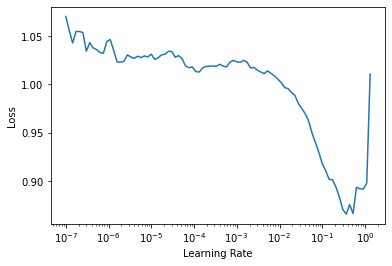

In [98]:
learn.lr_find()

In [99]:
learn.fit_flat_cos(1, 7e-2, wd=0.025)

epoch,train_loss,valid_loss,roc_auc,time
0,0.181550,0.110506,0.951297,01:01


In [100]:
learn.save('effb0-initial')

Path('models/effb0-initial.pth')

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=3.981071586167673e-06)

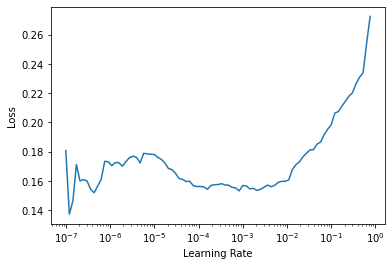

In [101]:
learn.unfreeze()
learn.lr_find()

We'll use a lower learning rate AND crank up the weight decay here, in the hopes of helping our model avoid overfitting

In [102]:
#learn = learn.load('effb0-initial')
#learn.unfreeze()
learn.fit_flat_cos(10, 3e-4, wd=0.125, cbs=[ReduceLROnPlateau(),
                                              SaveModelCallback()])
learn.save('effb0-small')

epoch,train_loss,valid_loss,roc_auc,time
0,0.139794,0.084254,0.966104,01:19
1,0.133327,0.073280,0.972873,01:19
2,0.118523,0.066495,0.974382,01:19
3,0.115649,0.066250,0.975744,01:19
4,0.114512,0.065188,0.973405,01:19
5,0.113992,0.062272,0.975418,01:19
6,0.109581,0.055366,0.979111,01:19
7,0.104907,0.059815,0.974517,01:19
8,0.100802,0.053745,0.978651,01:19
9,0.099325,0.054884,0.978309,01:19


Better model found at epoch 0 with valid_loss value: 0.08425429463386536.
Better model found at epoch 1 with valid_loss value: 0.07328017801046371.
Better model found at epoch 2 with valid_loss value: 0.06649549305438995.
Better model found at epoch 3 with valid_loss value: 0.06625036150217056.
Better model found at epoch 4 with valid_loss value: 0.06518799811601639.
Better model found at epoch 5 with valid_loss value: 0.06227235496044159.
Better model found at epoch 6 with valid_loss value: 0.05536572262644768.
Epoch 7: reducing lr to 2.7166593263094474e-05
Better model found at epoch 8 with valid_loss value: 0.053744539618492126.
Epoch 9: reducing lr to 3.9505435658350985e-10


Path('models/effb0-small.pth')

In [117]:
dls = get_dls(448, 448, 64)
dls.to('cuda')
learn = get_learner(dls, 'efficientnet_b0')
learn = learn.load('effb0-small')
learn.model.to('cuda');
#learn.lr_find()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=7.585775847473997e-07)

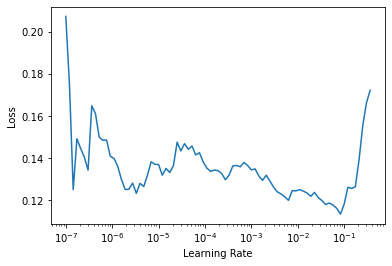

In [118]:
learn.lr_find()

In [119]:
learn.fit_flat_cos(1, 3e-2, wd=0.025)

epoch,train_loss,valid_loss,roc_auc,time
0,0.105924,0.058019,0.978403,02:28


In [120]:
learn.save('effb0-big-initial')

Path('models/effb0-big-initial.pth')

In [124]:
learn.load('effb0-big-initial');

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=7.585775847473997e-07)

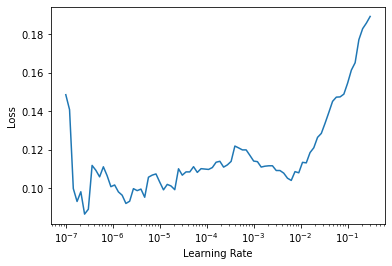

In [125]:
learn.unfreeze()
learn.lr_find()

In [126]:
learn.fit_flat_cos(10, 1e-5, wd=0.125, cbs=[ReduceLROnPlateau(),
                                              SaveModelCallback()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.094688,0.059738,0.978401,03:26
1,0.103327,0.058374,0.978518,03:26
2,0.103108,0.059182,0.978716,03:25
3,0.100181,0.058098,0.978904,03:25
4,0.102910,0.056842,0.979559,03:25
5,0.104569,0.055878,0.980490,03:25
6,0.098190,0.054777,0.981539,03:25
7,0.098027,0.052779,0.981738,03:25
8,0.095204,0.052947,0.981942,03:25
9,0.094254,0.052447,0.982068,03:25


Better model found at epoch 0 with valid_loss value: 0.0597376823425293.
Better model found at epoch 1 with valid_loss value: 0.05837373435497284.
Epoch 2: reducing lr to 1.0000000000000002e-06
Better model found at epoch 3 with valid_loss value: 0.058098115026950836.
Better model found at epoch 4 with valid_loss value: 0.05684191361069679.
Better model found at epoch 5 with valid_loss value: 0.05587777495384216.
Better model found at epoch 6 with valid_loss value: 0.05477684363722801.
Better model found at epoch 7 with valid_loss value: 0.052778761833906174.
Epoch 8: reducing lr to 3.4634470359810593e-07
Better model found at epoch 9 with valid_loss value: 0.052447106689214706.


In [127]:
learn.to_fp32()

In [128]:
learn.save('effb0-prog-res')

Path('models/effb0-prog-res.pth')

In the paper they insist that the labels must be one-hot-encoded. This seems unnecessary here, as shown below

In [126]:
ohe = nn.functional.one_hot(batch[1])
ohe.shape

torch.Size([128, 2])

In [130]:
ohe[:2], (0.4*ohe[0]), (0.6*ohe[1])

(tensor([[1, 0],
         [0, 1]]),
 tensor([0.4000, 0.0000]),
 tensor([0.0000, 0.6000]))

In [129]:
(0.4 * ohe[0]) + (0.6 * ohe[1])

tensor([0.4000, 0.6000])

In [132]:
batch[1][:2]

tensor([0, 1])

In [133]:
(0.4 * 0) + (0.6 * 1)

0.6